# A brief introduction to bond-calculus and $\mathcal{LBUC}$

## The basics

Import relevant libraries

In [1]:
%display latex

In [2]:
from ulbc import *
from flowstar import *
from ulbc.bondcalculus import *

Load bond-calculus model file

In [5]:
m = BondModel("/home/twright/Documents/PhD/hostnotebooks/WhelksAndLobsters.bond")

ExceptionPexpect: The command was not found or was not executable: bondwb.

Create process with given initial concentrations and affinity network

In [4]:
p = m.process("[1.0 .. 1.2] Whelk || [4 .. 6] Lobster with network N(0.8, 0.6, 0.3, 0.05, 2)"); p

BondProcess('[1.0 .. 1.2] Whelk || [4 .. 6] Lobster with network N(0.8, 0.6, 0.3, 0.05, 2)', <ulbc.bondcalculus.BondModel object at 0x7f8a52a9ac10>)

Export system of odes (question marks on values denote intervals)

In [5]:
s = p.as_system; s

Running cmd: 'savesage "[1.0 .. 1.2] Whelk || [4 .. 6] Lobster with network N(0.8, 0.6, 0.3, 0.05, 2)" "/tmp/bond-sage-script-zihu1moa.py"' ...


System(R, (x0, x1), [[4 .. 6], [0.99999999999999988 .. 1.2000000000000004]], (-2*x0*x1^2 - 0.05000000000000000?*x0^2 + 1.600000000000000?*x0*x1 - 0.05000000000000000?*x0, 0.3000000000000000?*x0*x1^2 - 0.2400000000000000?*x0*x1 - 0.600000000000000?*x1^2 + 0.600000000000000?*x1), varmap=bidict({'Lobster': x0, 'Whelk': x1}))

## Working with ODE systems

Systems of ODEs are represented in Python as System objects. There is at least some class-level documentation saying what you can do with them.

In [6]:
help(s)

Help on BondSystem in module ulbc.bondcalculus object:

class BondSystem(System)
 |  BondSystem(R, x: tuple, y0: tuple, y: tuple, affinity_network: str, model: Union[ForwardRef('BondModel'), NoneType] = None, varmap: Union[dict, NoneType] = None, y0_ctx: Union[tuple, NoneType] = None)
 |  
 |  Method resolution order:
 |      BondSystem
 |      System
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, R, x: tuple, y0: tuple, y: tuple, affinity_network: str, model: Union[ForwardRef('BondModel'), NoneType] = None, varmap: Union[dict, NoneType] = None, y0_ctx: Union[tuple, NoneType] = None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  process_from_state(self, state: List[Any]) -> 'BondProcess'
 |  
 |  with_y0(self, y0, y0_ctx: Union[tuple, NoneType] = None)
 |  
 |  ----------------------------------------------------------------------
 |  Class methods defined here:
 |  
 |  load_from_script(filename: str, model: Union[Forwa

They define a sage variable for each dimension of the system (extracted from the bond-calculus model)

In [7]:
s.x

(x0, x1)

In [8]:
s.varmap

bidict({'Lobster': x0, 'Whelk': x1})

They also include the extracted ODEs

In [9]:
s.y[1]

0.3000000000000000?*x0*x1^2 - 0.2400000000000000?*x0*x1 - 0.600000000000000?*x1^2 + 0.600000000000000?*x1

In [10]:
s.y[0]

-2*x0*x1^2 - 0.05000000000000000?*x0^2 + 1.600000000000000?*x0*x1 - 0.05000000000000000?*x0

## Streamline plot

We can, for example, produce a streamline plot and mark on the initial condition (box):

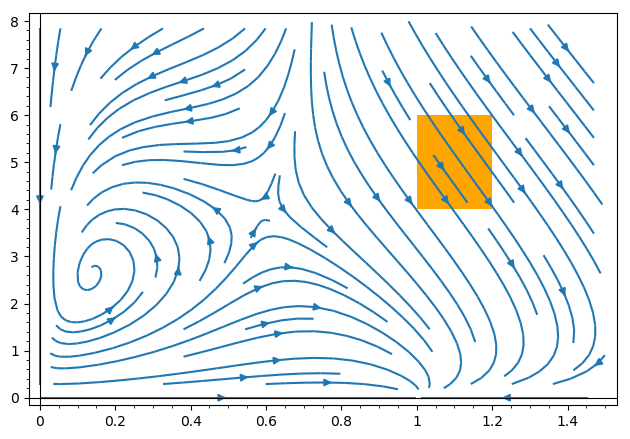

In [11]:
out = s.streamline_plot((s.v('Whelk'), 0, 1.5), (s.v('Lobster'), 0, 8))
out += polygon([(s.y0[1].lower(), s.y0[0].lower()),
            (s.y0[1].lower(), s.y0[0].upper()),
            (s.y0[1].upper(), s.y0[0].upper()),
            (s.y0[1].upper(), s.y0[0].lower())],
              color='orange')
out.set_aspect_ratio(1/8)
out

If you look at the sourcecode of System.streamline_plot you will see this simply wraps the plotting methods of the Sage computer algebra system (http://doc.sagemath.org/html/en/reference/plotting/sage/plot/plot.html).

If you prefer you could also use pyplot or any other plotting library with a little extra work.

## Other plots

You can use any other Sage plotting methods to produce graphs or indeed write arbitrary Python code (and any of the scientific/numerical python libraries) to produce more complex plots.

In many cases it might be necessary to cast the system of odes to replace intervals with normal floating point numbers (Sage Reals).

In [12]:
# Cast interval ODEs to normal floating point numbers
RQ, xq = RR['x0, x1'].objgens()
Qodes = [RQ(yi) for yi in s.y]
xq, Qodes

((x0, x1),
 [-2.00000000000000*x0*x1^2 - 0.0500000000000000*x0^2 + 1.60000000000000*x0*x1 - 0.0500000000000000*x0,
  0.300000000000000*x0*x1^2 - 0.240000000000000*x0*x1 - 0.600000000000000*x1^2 + 0.600000000000000*x1])

Then we can solve the ODEs (for a given point initial condition $\mathbf{x}_0 = (1.1, 5)$) using Sage's desolve_odeint (http://doc.sagemath.org/html/en/reference/calculus/sage/calculus/desolvers.html#sage.calculus.desolvers.desolve_odeint)

In [22]:
timepoints = srange(0,10,0.1)
initials = [1.1, 5]

In [23]:
sln = desolve_odeint(Qodes, initials, timepoints, list(xq))

The result can then be plotted

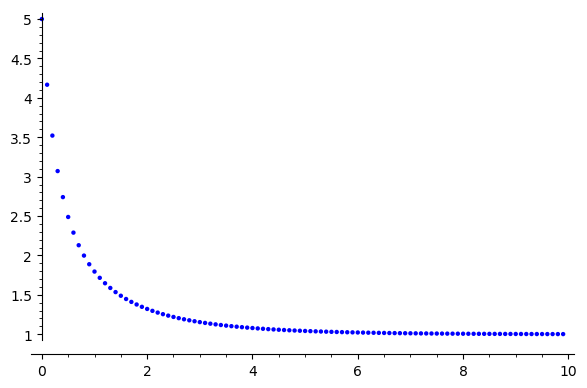

In [24]:
points(zip(timepoints, [y[1] for y in sln]))

A little more complicatedly, you can also use scipy's solve_ivp

In [26]:
from scipy.integrate import solve_ivp
from ulbc.matricies import vec_to_numpy, mat_to_numpy, convert_vec, sympy_gens

# Make callable function for odes (and jacobian matrix)
f = vec_to_numpy(RQ, Qodes)
jac = mat_to_numpy(RQ, sage.jacobian(Qodes, RQ.gens()))
sln = solve_ivp(f,
                (0, 10),
                initials,
                method='LSODA',
                jac=jac,
                vectorized=True,
                dense_output=True)

And then the solution may be plotted as a continuous function

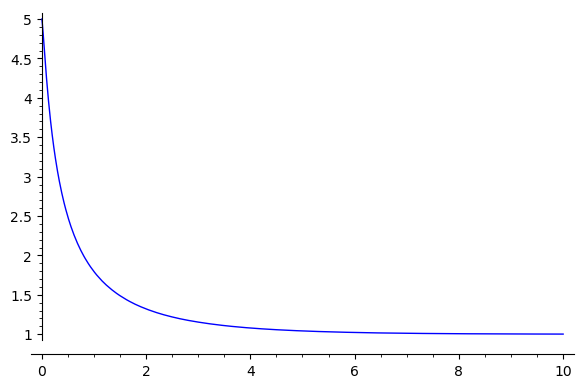

In [30]:
plot(lambda t: sln.sol(t)[1], (0, 10))

## Flowstar Reachability

You can also use the flow* validated integrator to compute sound enclosures of the trajectories of a system.

In [93]:
r = s.reach(5, order=5, step=(0.01, 0.2),
    precondition=1,
    estimation=1e-3,
    integrationScheme=2,
    cutoff_threshold=1e-5)

calling reach with y0 = ['[4.0000000000000000 .. 6.0000000000000000]', '[0.99999999999999988 .. 1.2000000000000004]']
ode in polynomial ring
_handle_initials called!
vars = [x0, x1]
C = [4.0..6.0]
C = [0.9999999999999999..1.2000000000000004]


var_id_x = 1
var_id_y = 0


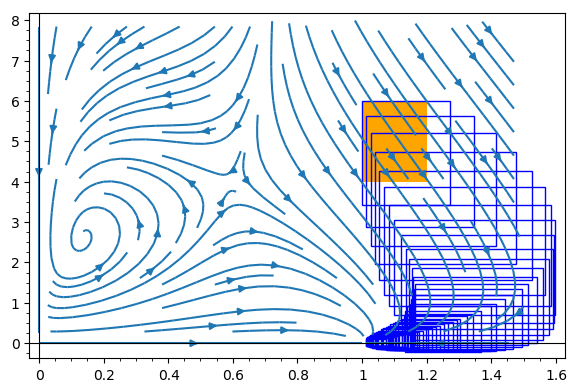

In [101]:
out1 = out + r.sage_interval_plot('x1', 'x0')
out1.set_aspect_ratio(1/8)
out1

## $\mathcal{LBUC}$ Formulae

Finally, you can check the truth of $\mathcal{LBUC}$ formulae (plotted over time of checking)

In [111]:
P = Atomic((var("Whelk") - 1)^2 + var("Lobster")^2 > 0.2); P

Atomic(Lobster^2 + (Whelk - 1)^2 > 0.200000000000000)

Precomposed systems in 5.245208740234375e-06 sec
calling reach with y0 = ['[4.0000000000000000 .. 6.0000000000000000]', '[0.99999999999999988 .. 1.2000000000000004]']
ode in polynomial ring
_handle_initials called!
vars = [x0, x1]
C = [4.0..6.0]
C = [0.9999999999999999..1.2000000000000004]
Computed 125 flowpipes in 6.00508451461792 sec
PolyObserver(x0^2 + x1^2 - 2*x1 + 0.8000000000000000?, <flowstar.reachability.Reach object at 0x558a313044c0>, 0 symbolic_composition=False, tentative_unpreconditioning=True, mask=None)
symbolic_composition=False, tentative_unpreconditioning=True
roots(space_domain=None, epsilon=1e-05, verbosity=0)
roots = [[0.76843267302404838 .. 2.9316460837390537]]
domain = [0.0000000000000000 .. 10.000000000000000]
roots = [[0.76843267302404838 .. 2.9316460837390537]]
seg_domain = [0.0000000000000000 .. 10.000000000000000]
roots = [[0.76843267302404838 .. 2.9316460837390537]]
Monitored signal in 3.4838430881500244 sec


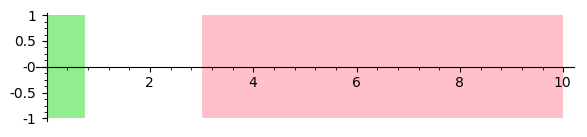

In [116]:
P.signal_for_system(s, 10, precondition=1,
    estimation=1e-3,
    integrationScheme=2,
    cutoff_threshold=1e-5).plot()

Precomposed systems in 1.1205673217773438e-05 sec
calling reach with y0 = ['[4.0000000000000000 .. 6.0000000000000000]', '[0.99999999999999988 .. 1.2000000000000004]']
ode in polynomial ring
_handle_initials called!
vars = [x0, x1]
C = [4.0..6.0]
C = [0.9999999999999999..1.2000000000000004]
Computed 145 flowpipes in 6.225687026977539 sec
PolyObserver(x0^2 + x1^2 - 2*x1 + 0.8000000000000000?, <flowstar.reachability.Reach object at 0x558a320d8010>, 0 symbolic_composition=False, tentative_unpreconditioning=True, mask=None)
symbolic_composition=False, tentative_unpreconditioning=True
roots(space_domain=None, epsilon=1e-05, verbosity=0)
roots = [[0.76843267302404838 .. 2.9316460837390537]]
domain = [0.0000000000000000 .. 12.000000000000002]
roots = [[0.76843267302404838 .. 2.9316460837390537]]
seg_domain = [0.0000000000000000 .. 12.000000000000002]
roots = [[0.76843267302404838 .. 2.9316460837390537]]
Monitored signal in 3.5312962532043457 sec


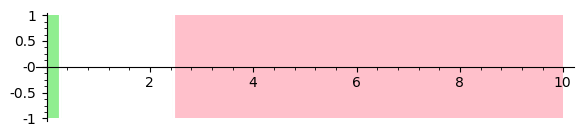

In [118]:
F(RIF(0.5, 2), P).signal_for_system(s, 10, precondition=1,
    estimation=1e-3,
    integrationScheme=2,
    cutoff_threshold=1e-5).plot()

This also has various magical 'make everything faster/better' flags you might want to experiment with

Precomposed systems in 1.1682510375976562e-05 sec
calling reach with y0 = ['[4.0000000000000000 .. 6.0000000000000000]', '[0.99999999999999988 .. 1.2000000000000004]']
ode in polynomial ring
_handle_initials called!
vars = [x0, x1]
C = [4.0..6.0]
C = [0.9999999999999999..1.2000000000000004]
Computed 145 flowpipes in 6.374889612197876 sec
PolyObserver(x0^2 + x1^2 - 2*x1 + 0.8000000000000000?, <flowstar.reachability.Reach object at 0x558a30f34de0>, 0 symbolic_composition=False, tentative_unpreconditioning=True, mask=Mask([0.0000000000000000 .. 12.001000000000002], [[0.50000000000000000 .. 12.001000000000002]]))
symbolic_composition=False, tentative_unpreconditioning=True
roots(space_domain=None, epsilon=1e-05, verbosity=0)
roots = [[0.76843267302404838 .. 2.9316460837390537]]
domain = [0.0000000000000000 .. 12.000000000000002]
roots = [[0.76843267302404838 .. 2.9316460837390537]]
seg_domain = [0.50000000000000000 .. 12.001000000000002]
roots = [[0.76843267302404838 .. 2.9316460837390537]

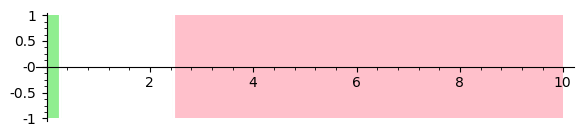

In [119]:
F(RIF(0.5, 2), P).signal_for_system(s, 10, precondition=1,
    estimation=1e-3,
    integrationScheme=2,
    cutoff_threshold=1e-5,
    use_masks=True).plot()

Precomposed systems in 9.298324584960938e-06 sec
calling reach with y0 = ['[4.0000000000000000 .. 6.0000000000000000]', '[0.99999999999999988 .. 1.2000000000000004]']
ode in polynomial ring
_handle_initials called!
vars = [x0, x1]
C = [4.0..6.0]
C = [0.9999999999999999..1.2000000000000004]
Computed 145 flowpipes in 6.168298721313477 sec
PolyObserver(x0^2 + x1^2 - 2*x1 + 0.8000000000000000?, <flowstar.reachability.Reach object at 0x558a322f3c60>, 0 symbolic_composition=True, tentative_unpreconditioning=True, mask=None)
symbolic_composition=True, tentative_unpreconditioning=True
roots(space_domain=None, epsilon=1e-05, verbosity=0)
roots = [[0.71755595465727350 .. 2.3520333237477234], [2.4461257129884059 .. 2.4486354504129451]]
domain = [0.0000000000000000 .. 12.000000000000002]
roots = [[0.71755595465727350 .. 2.3520333237477234], 
 [2.4461257129884059 .. 2.4486354504129451]]
seg_domain = [0.0000000000000000 .. 12.000000000000002]
roots = [[0.71755595465727350 .. 2.3520333237477234], 
 [

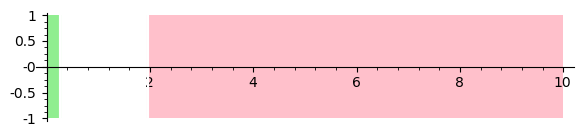

In [120]:
F(RIF(0.5, 2), P).signal_for_system(s, 10, precondition=1,
    estimation=1e-3,
    integrationScheme=2,
    cutoff_threshold=1e-5,
    symbolic_composition=True).plot()

calling reach with y0 = ['[4.0000000000000000 .. 6.0000000000000000]', '[0.99999999999999988 .. 1.2000000000000004]']
ode in polynomial ring
_handle_initials called!
vars = [x0, x1]
C = [4.0..6.0]
C = [0.9999999999999999..1.2000000000000004]
contexts = ['[4.0..6.0]', '[0.9999999999999999..1.2000000000000004]']
statics  = []
Computed 145 flowpipes in 3.814697265625e-06 sec
PolyObserver(x0^2 + x1^2 - 2*x1 + 0.8000000000000000?, <flowstar.reachability.Reach object at 0x558a324d1cb0>, 0 symbolic_composition=True, tentative_unpreconditioning=True, mask=None)
var_names = [b'local_t', b'x0', b'x1']
res = b'(([0.7999999999 , 0.8000000001]) + ([-2.0000000000 , -2.0000000000] * x1) + ([1.0000000000 , 1.0000000000] * x1^2) + ([1.0000000000 , 1.0000000000] * x0^2))'
var_names = [b'local_t', b'x0', b'x1']
res = b''
PolyObserver((([0.7999999999 , 0.8000000001]) + ([-2.0000000000 , -2.0000000000] * x1) + ([1.0000000000 , 1.0000000000] * x1^2) + ([1.0000000000 , 1.0000000000] * x0^2)), <flowstar.reach

self.reach.vars = [x0, x1]
var_names = [b'local_t', b'x0', b'x1']
res = b'(([0.7999999999 , 0.8000000001]) + ([-2.0000000000 , -2.0000000000] * x1) + ([1.0000000000 , 1.0000000000] * x1^2) + ([1.0000000000 , 1.0000000000] * x0^2))'
var_names = [b'local_t', b'x0', b'x1']
res = b''
PolyObserver((([0.7999999999 , 0.8000000001]) + ([-2.0000000000 , -2.0000000000] * x1) + ([1.0000000000 , 1.0000000000] * x1^2) + ([1.0000000000 , 1.0000000000] * x0^2)), <flowstar.reachability.Reach object at 0x558a324d1cb0>,  symbolic_composition=True, tentative_unpreconditioning=True, mask=Mask([0.0000000000000000 .. 12.001000000000000], [[0.50000000000000000 .. 12.001000000000000]]))
self.reach.vars = [x0, x1]
symbolic_composition=True, tentative_unpreconditioning=True
roots(space_domain=None, epsilon=1e-05, verbosity=0)
roots = [[1.4744160248003987 .. 1.4826141837607290], [1.5335181299995224 .. 1.9656248170868365]]
domain = [0.0000000000000000 .. 12.000000000000000]
roots = [[1.4744160248003987 .. 1.48261

seg_domain = [0.50000000000000000 .. 12.001000000000000]
roots = [[1.4650386916708812 .. 1.4826141837607290], 
 [1.4899336924920796 .. 1.9444764661636993]]
self.reach.vars = [x0, x1]
var_names = [b'local_t', b'x0', b'x1']
res = b'(([0.7999999999 , 0.8000000001]) + ([-2.0000000000 , -2.0000000000] * x1) + ([1.0000000000 , 1.0000000000] * x1^2) + ([1.0000000000 , 1.0000000000] * x0^2))'
var_names = [b'local_t', b'x0', b'x1']
res = b''
PolyObserver((([0.7999999999 , 0.8000000001]) + ([-2.0000000000 , -2.0000000000] * x1) + ([1.0000000000 , 1.0000000000] * x1^2) + ([1.0000000000 , 1.0000000000] * x0^2)), <flowstar.reachability.Reach object at 0x558a324d1cb0>,  symbolic_composition=True, tentative_unpreconditioning=True, mask=Mask([0.0000000000000000 .. 12.001000000000000], [[0.50000000000000000 .. 12.001000000000000]]))
self.reach.vars = [x0, x1]
symbolic_composition=True, tentative_unpreconditioning=True
roots(space_domain=None, epsilon=1e-05, verbosity=0)
roots = [[1.2423789927300066 .. 

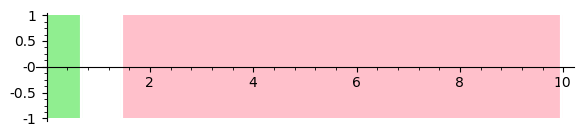

In [122]:
F(RIF(0.5, 2), P).context_signal_for_system(s, 10, precondition=1,
    estimation=1e-3,
    integrationScheme=2,
    cutoff_threshold=1e-5,
    use_masks=True,
    symbolic_composition=True).refined_signal(2).plot()